# Pix2Pix CycleGAN

Adapted from https://learnopencv.com/paired-image-to-image-translation-pix2pix/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd
import math

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
    #Tensor = torch.cuda.FloatTensor
else:
    device = 'cpu'
    #Tensor = torch.Tensor

# Fake Dataset

In [4]:
'''n_data=10000
control_data = torch.rand( (n_data, *control_shape)) #Uniform
signal_data = torch.randn((n_data, *signal_shape))  #Gaussian

val_control_data = torch.rand( (n_data, *control_shape)) #Uniform
val_signal_data = torch.randn((n_data, *signal_shape))  #Gaussian'''

'n_data=10000\ncontrol_data = torch.rand( (n_data, *control_shape)) #Uniform\nsignal_data = torch.randn((n_data, *signal_shape))  #Gaussian\n\nval_control_data = torch.rand( (n_data, *control_shape)) #Uniform\nval_signal_data = torch.randn((n_data, *signal_shape))  #Gaussian'

In [5]:
'''fake_dataset =torch.cat([signal_data,control_data],dim=1) #one block, signal data at channel 0, control data at channels >0
val_fake_dataset =torch.cat([val_signal_data,val_control_data],dim=1)
batch_size = 128'''

'fake_dataset =torch.cat([signal_data,control_data],dim=1) #one block, signal data at channel 0, control data at channels >0\nval_fake_dataset =torch.cat([val_signal_data,val_control_data],dim=1)\nbatch_size = 128'

## Real Dataset (too small for now)

In [6]:
df = pd.read_pickle('/content/drive/MyDrive/Dataset_0_100.pkl')
n_data=df.shape[0]
n_train=int(0.9*n_data)
batch_size = 24

In [7]:
#create a df with only aux channels
df_aux = pd.DataFrame(df[['V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR']])

In [8]:
signal_data_train=torch.stack([torch.stack([df['V1:LSC_MICH_ERR'][i]]) for i in range(n_train)])
aux_data_train=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1]]) for i in range(n_train)])
train_data=torch.cat([signal_data_train,aux_data_train],dim=1)
print(signal_data_train.shape)
print(aux_data_train.shape)

signal_data_test=torch.stack([torch.stack([df['V1:LSC_MICH_ERR'][i]]) for i in range(n_train,n_data)])
aux_data_test=torch.stack([torch.stack([df_aux.loc[i][0],df_aux.loc[i][1]]) for i in range(n_train,n_data)])
test_data=torch.cat([signal_data_test,aux_data_test],dim=1)
print(signal_data_test.shape)
print(aux_data_test.shape)

torch.Size([90, 1, 65536])
torch.Size([90, 2, 65536])
torch.Size([10, 1, 65536])
torch.Size([10, 2, 65536])


In [9]:
dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

In [10]:
test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

## Model

In [11]:
def init_weights(net, init_type='normal', scaling=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function

## Generator

### Convolutional UNet

In [12]:
class Decoder(nn.Module):
    def __init__(self, in_channels, kernel_size=5):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.Conv1d(64, 128,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.Conv1d(128, 256,kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.Conv1d(256, 1, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

    def _forward_features(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)
        return x

    def forward(self, x):
        return self._forward_features(x)

In [13]:
'''
model=Decoder(2).to(device)
for batch in dataloader:
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    out=model(input)
    print(out.shape)
    print(input.shape)
    print((out-target).sum())
    break'''

'\nmodel=Decoder(2).to(device)\nfor batch in dataloader:\n    target = batch[:,0].unsqueeze(1).to(device)\n    input = batch[:,1:].to(device)\n    out=model(input)\n    print(out.shape)\n    print(input.shape)\n    print((out-target).sum())\n    break'

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.ReLU()):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            activation,
            nn.Linear(out_features, in_features)
        )

    def forward(self, x):
        return x + self.block(x)

class ResMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_blocks):
        super(ResMLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size) for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x.view((x.shape[0],-1)))
        for block in self.hidden_layers:
            x = block(x)
        x = self.output_layer(x).unsqueeze(1)
        return x


In [15]:
''''input_size = 65536*2
hidden_size = 128
output_size = 65536
num_blocks = 3
generator = ResMLP(input_size, hidden_size, output_size, num_blocks).to(device)''''

In [16]:
class conbr_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, stride, dilation):
        super(conbr_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer, kernel_size=kernel_size, stride=stride, dilation = dilation, padding = 3, bias=True)
        self.bn = nn.BatchNorm1d(out_layer)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn(x)
        out = self.relu(x)

        return out

class se_block(nn.Module):
    def __init__(self,in_layer, out_layer):
        super(se_block, self).__init__()

        self.conv1 = nn.Conv1d(in_layer, out_layer//8, kernel_size=1, padding=0)
        self.conv2 = nn.Conv1d(out_layer//8, in_layer, kernel_size=1, padding=0)
        self.fc = nn.Linear(1,out_layer//8)
        self.fc2 = nn.Linear(out_layer//8,out_layer)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):

        x_se = nn.functional.adaptive_avg_pool1d(x,1)
        x_se = self.conv1(x_se)
        x_se = self.relu(x_se)
        x_se = self.conv2(x_se)
        x_se = self.sigmoid(x_se)

        x_out = torch.add(x, x_se)
        return x_out

class re_block(nn.Module):
    def __init__(self, in_layer, out_layer, kernel_size, dilation):
        super(re_block, self).__init__()

        self.cbr1 = conbr_block(in_layer,out_layer, kernel_size, 1, dilation)
        self.cbr2 = conbr_block(out_layer,out_layer, kernel_size, 1, dilation)
        self.seblock = se_block(out_layer, out_layer)

    def forward(self,x):

        x_re = self.cbr1(x)
        x_re = self.cbr2(x_re)
        x_re = self.seblock(x_re)
        x_out = torch.add(x, x_re)
        return x_out

class UNET_1D(nn.Module):
    def __init__(self ,input_dim,layer_n,kernel_size,depth,out_channels):
        super(UNET_1D, self).__init__()
        self.input_dim = input_dim
        self.layer_n = layer_n
        self.kernel_size = kernel_size
        self.depth = depth

        self.AvgPool1D1 = nn.AvgPool1d(input_dim, stride=5)
        self.AvgPool1D2 = nn.AvgPool1d(input_dim, stride=25)
        self.AvgPool1D3 = nn.AvgPool1d(input_dim, stride=125)

        self.layer1 = self.down_layer(self.input_dim, self.layer_n, self.kernel_size,1, 2)
        self.layer2 = self.down_layer(self.layer_n, int(self.layer_n*2), self.kernel_size,5, 2)
        self.layer3 = self.down_layer(int(self.layer_n*2)+int(self.input_dim), int(self.layer_n*3), self.kernel_size,5, 2)
        self.layer4 = self.down_layer(int(self.layer_n*3)+int(self.input_dim), int(self.layer_n*4), self.kernel_size,5, 2)
        self.layer5 = self.down_layer(int(self.layer_n*4)+int(self.input_dim), int(self.layer_n*5), self.kernel_size,4, 2)

        self.cbr_up1 = conbr_block(int(self.layer_n*7), int(self.layer_n*3), self.kernel_size, 1, 1)
        self.cbr_up2 = conbr_block(int(self.layer_n*5), int(self.layer_n*2), self.kernel_size, 1, 1)
        self.cbr_up3 = conbr_block(int(self.layer_n*3), self.layer_n, self.kernel_size, 1, 1)
        self.upsample = nn.Upsample(scale_factor=5, mode='nearest')
        self.upsample1 = nn.Upsample(scale_factor=5, mode='nearest')

        self.outcov = nn.Conv1d(self.layer_n, out_channels, kernel_size=self.kernel_size, stride=1,padding = 3)


    def down_layer(self, input_layer, out_layer, kernel, stride, depth):
        block = []
        block.append(conbr_block(input_layer, out_layer, kernel, stride, 1))
        for i in range(depth):
            block.append(re_block(out_layer,out_layer,kernel,1))
        return nn.Sequential(*block)

    def forward(self, x):

        pool_x1 = self.AvgPool1D1(x)
        pool_x2 = self.AvgPool1D2(x)
        pool_x3 = self.AvgPool1D3(x)

        #############Encoder#####################

        out_0 = self.layer1(x)
        out_1 = self.layer2(out_0)

        x = torch.cat([out_1,pool_x1],1)
        out_2 = self.layer3(x)

        x = torch.cat([out_2,pool_x2],1)
        x = self.layer4(x)

        #############Decoder####################

        up = self.upsample1(x)
        up = torch.cat([up,out_2],1)
        up = self.cbr_up1(up)

        up = self.upsample(up)
        up = torch.cat([up,out_1],1)
        up = self.cbr_up2(up)

        up = self.upsample(up)
        up = torch.cat([up,out_0],1)
        up = self.cbr_up3(up)

        out = self.outcov(up)

        #out = nn.functional.softmax(out,dim=2)

        return out

In [22]:
def train_decoder(num_epochs,generator,criterion,optimizer,dataloader,val_loader):
    loss_plot =[]
    val_loss_plot =[]
    for epoch in tqdm(range(1,num_epochs+1)):
        epoch_loss =[]
        for i, batch in enumerate(dataloader):
            target = batch[:,0].unsqueeze(1).to(device)
            input = batch[:,1:].to(device)
            optimizer.zero_grad()
            generated = generator(input)
            loss=criterion(generated,target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.detach().cpu().numpy())
        val_loss =[]
        for batch in(tqdm(val_loader)):
            target = batch[:,0].unsqueeze(1).to(device)
            input = batch[:,1:].to(device)
            with torch.no_grad():
                generated = generator(input)
                loss=criterion(generated,target)
                val_loss.append(loss.detach().cpu().numpy())
        loss_plot.append(np.mean(epoch_loss))
        val_loss_plot.append(np.mean(val_loss))
        print('epoch: {} loss: {} val loss: {}'.format(epoch,loss_plot[-1],val_loss_plot[-1]))
    return loss_plot, val_loss_plot

def log_cosh_loss(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    def _log_cosh(x: torch.Tensor) -> torch.Tensor:
        return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(y_pred - y_true))

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(
        self, y_pred: torch.Tensor, y_true: torch.Tensor
    ) -> torch.Tensor:
        return log_cosh_loss(y_pred, y_true)
def generate_data(generator,batch):
    target = batch[:,0].unsqueeze(1).to(device)
    input = batch[:,1:].to(device)
    with torch.no_grad():
        generated = generator(input)
    return generated


In [23]:
#generator =UNET_1D(2,layer_n=32,kernel_size=7,depth=1,out_channels=1).to(device)
generator = Decoder(2).to(device)
init_weights(generator, 'normal', scaling=0.02)
print(generator)

initialize network with normal
Decoder(
  (conv1): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv1d(256, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)


In [24]:
# loss function and optimiser

#criterion = torch.nn.L1Loss()
criterion = LogCoshLoss()

#criterion = nn.MSELoss()

lr=0.001

G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr )

In [25]:
loss_plot, val_loss_plot =train_decoder(100,generator,criterion,G_optimizer,dataloader,test_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 1 loss: 0.011019821278750896 val loss: 0.016499852761626244


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 2 loss: 0.00953212846070528 val loss: 0.01676109991967678


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 3 loss: 0.007766753435134888 val loss: 0.01465639378875494


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 4 loss: 0.006804227828979492 val loss: 0.011389655992388725


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 5 loss: 0.004129065666347742 val loss: 0.0064176092855632305


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 6 loss: 0.0017307344824075699 val loss: 0.0023236682172864676


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 7 loss: 0.0013322962913662195 val loss: 0.0017176548717543483


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 8 loss: 0.0005416998756118119 val loss: 0.0028118849731981754


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 9 loss: 0.0004702515434473753 val loss: 0.002075198572129011


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 10 loss: 0.00034887329093180597 val loss: 0.001341883442364633


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 11 loss: 0.00020665979536715895 val loss: 0.0007799338782206178


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 12 loss: 0.0001564103295095265 val loss: 0.0008097818354144692


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 13 loss: 8.990403148345649e-05 val loss: 0.0007827518857084215


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 14 loss: 6.641467189183459e-05 val loss: 0.0006245169788599014


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 15 loss: 3.497039870126173e-05 val loss: 0.00041582269477657974


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 16 loss: 3.0522125598508865e-05 val loss: 0.0003252303577028215


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 17 loss: 1.8939879737445153e-05 val loss: 0.00034047485678456724


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 18 loss: 1.7858836145023815e-05 val loss: 0.0002637040743138641


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 19 loss: 1.2394394616421778e-05 val loss: 0.00019180648087058216


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 20 loss: 1.1124055163236335e-05 val loss: 0.000182712625246495


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 21 loss: 8.520729352312628e-06 val loss: 0.00018151492986362427


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 22 loss: 8.252241059381049e-06 val loss: 0.00015206365787889808


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 23 loss: 7.255999662447721e-06 val loss: 0.00013114942703396082


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 24 loss: 6.14222062722547e-06 val loss: 0.00013364390179049224


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 25 loss: 5.220232196734287e-06 val loss: 0.00012295925989747047


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 26 loss: 4.648321009881329e-06 val loss: 0.00011980593990301713


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 27 loss: 4.1937623791454826e-06 val loss: 0.00011501792323542759


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 28 loss: 3.7105119190528058e-06 val loss: 0.00011044253187719733


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 29 loss: 3.5837638279190287e-06 val loss: 0.00011066102888435125


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 30 loss: 3.7971215078869136e-06 val loss: 0.00010583051334833726


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 31 loss: 4.172509761701804e-06 val loss: 9.729371959110722e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 32 loss: 3.731070592039032e-06 val loss: 9.458793647354469e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 33 loss: 3.265944997110637e-06 val loss: 9.482392488280311e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 34 loss: 3.1372278499475215e-06 val loss: 8.755917951930314e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 35 loss: 2.634086968100746e-06 val loss: 8.331849676324055e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 36 loss: 2.659153096828959e-06 val loss: 8.177567360689864e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 37 loss: 2.6834081836568657e-06 val loss: 8.180780423572287e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 38 loss: 2.353684976696968e-06 val loss: 8.149333734763786e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 39 loss: 2.5276576707256027e-06 val loss: 7.562137761851773e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 40 loss: 2.131603878297028e-06 val loss: 7.224746514111757e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 41 loss: 2.2735857783118263e-06 val loss: 6.917848804732785e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 42 loss: 2.3073412194207776e-06 val loss: 7.13602639734745e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 43 loss: 2.1399705474323127e-06 val loss: 6.938392471056432e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 44 loss: 2.0877550923614763e-06 val loss: 6.543564813910052e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 45 loss: 1.938049990712898e-06 val loss: 6.293249316513538e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 46 loss: 1.6550065993214957e-06 val loss: 6.549987301696092e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 47 loss: 1.956741925823735e-06 val loss: 5.887266524950974e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 48 loss: 2.2815520424046554e-06 val loss: 6.182211654959247e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 49 loss: 2.3461252567358315e-06 val loss: 5.988122575217858e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 50 loss: 1.8934256331704091e-06 val loss: 5.6387041695415974e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 51 loss: 1.8232664160677814e-06 val loss: 5.981187496217899e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 52 loss: 1.7268578176299343e-06 val loss: 5.463662091642618e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 53 loss: 1.5431724023073912e-06 val loss: 5.1405688282102346e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 54 loss: 1.863209945440758e-06 val loss: 5.096941094961949e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 55 loss: 1.537277057650499e-06 val loss: 5.671679537044838e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 56 loss: 1.838575599322212e-06 val loss: 4.9647260311758146e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 57 loss: 1.2782536487065954e-06 val loss: 5.0002254283754155e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 58 loss: 1.8459124930814141e-06 val loss: 4.8071549827000126e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 59 loss: 1.7142859860541648e-06 val loss: 4.856090890825726e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 60 loss: 1.5512569007114507e-06 val loss: 4.476753747439943e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 61 loss: 1.8567327515484067e-06 val loss: 4.626061490853317e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 62 loss: 1.1683156344588497e-06 val loss: 4.643814099836163e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 63 loss: 1.1349712849550997e-06 val loss: 4.152638211962767e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 64 loss: 1.1769966477004346e-06 val loss: 4.306787741370499e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 65 loss: 1.1230208656343166e-06 val loss: 4.2766067053889856e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 66 loss: 1.1433974123065127e-06 val loss: 3.924306292901747e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 67 loss: 5.794217941001989e-06 val loss: 4.8132231313502416e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 68 loss: 2.9879518478992395e-05 val loss: 9.212143049808219e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 69 loss: 5.537594188353978e-05 val loss: 5.806457556900568e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 70 loss: 1.2835610505135264e-05 val loss: 6.93956098984927e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 71 loss: 3.181823922204785e-05 val loss: 6.436549301724881e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 72 loss: 1.5311732568079606e-05 val loss: 4.641362465918064e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 73 loss: 9.950006642611697e-06 val loss: 4.0548744436819106e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 74 loss: 3.5068680972472066e-06 val loss: 6.606537499465048e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 75 loss: 7.895057933637872e-06 val loss: 3.32124182023108e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 76 loss: 8.7022617663024e-06 val loss: 6.87626379658468e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 77 loss: 1.1492704288684763e-05 val loss: 4.696173709817231e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 78 loss: 1.559055453981273e-05 val loss: 3.153328361804597e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 79 loss: 1.1420364899095148e-05 val loss: 6.78959913784638e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 80 loss: 1.0580767593637574e-05 val loss: 4.1546089050825685e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 81 loss: 1.651430102356244e-05 val loss: 9.371260966872796e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 82 loss: 2.2790814909967594e-05 val loss: 3.9568829379277304e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 83 loss: 1.0796053174999543e-05 val loss: 3.396881584194489e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 84 loss: 2.1186324374866672e-05 val loss: 6.828489131294191e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 85 loss: 2.4781082174740732e-05 val loss: 6.351881165755913e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 86 loss: 2.836497878888622e-05 val loss: 0.00011671442916849628


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 87 loss: 7.482703949790448e-05 val loss: 0.00011547080066520721


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 88 loss: 4.39552532043308e-05 val loss: 3.6599591112462804e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 89 loss: 3.9289076084969565e-05 val loss: 4.7674529923824593e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 90 loss: 2.159714676963631e-05 val loss: 4.735317997983657e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 91 loss: 1.329882798017934e-05 val loss: 4.341852036304772e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 92 loss: 1.038454138324596e-05 val loss: 2.591261363704689e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 93 loss: 9.671918633102905e-06 val loss: 2.9182525395299308e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 94 loss: 9.751420293468982e-06 val loss: 2.8614875191124156e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 95 loss: 1.459349732613191e-05 val loss: 4.877954415860586e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 96 loss: 1.2008887097181287e-05 val loss: 4.536599590210244e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 97 loss: 7.669769729545806e-06 val loss: 1.8437693142914213e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 98 loss: 3.702174353747978e-06 val loss: 2.3301861801883206e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 99 loss: 4.31072794526699e-06 val loss: 2.4579367163823918e-05


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 100 loss: 5.081831659481395e-06 val loss: 3.952649058192037e-05


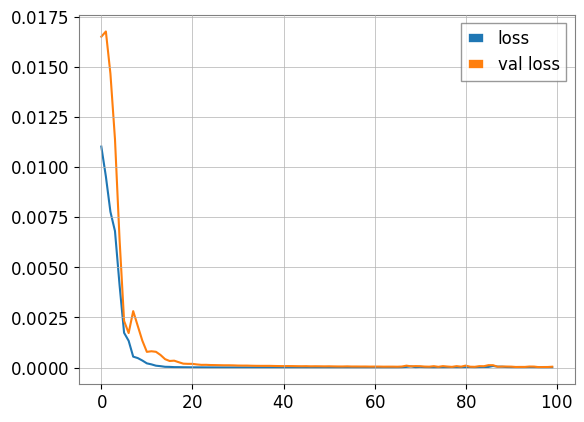

In [30]:
plt.plot(loss_plot,label='loss')
plt.plot(val_loss_plot,label='val loss')
plt.legend()

# Plotting The Syntetic Signals

In [31]:
try:
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    from gwpy.timeseries import TimeSeries

In [32]:
for batch in(tqdm(test_dataloader)):
    generated=generate_data(generator,batch)
    break

  0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
n_data=2

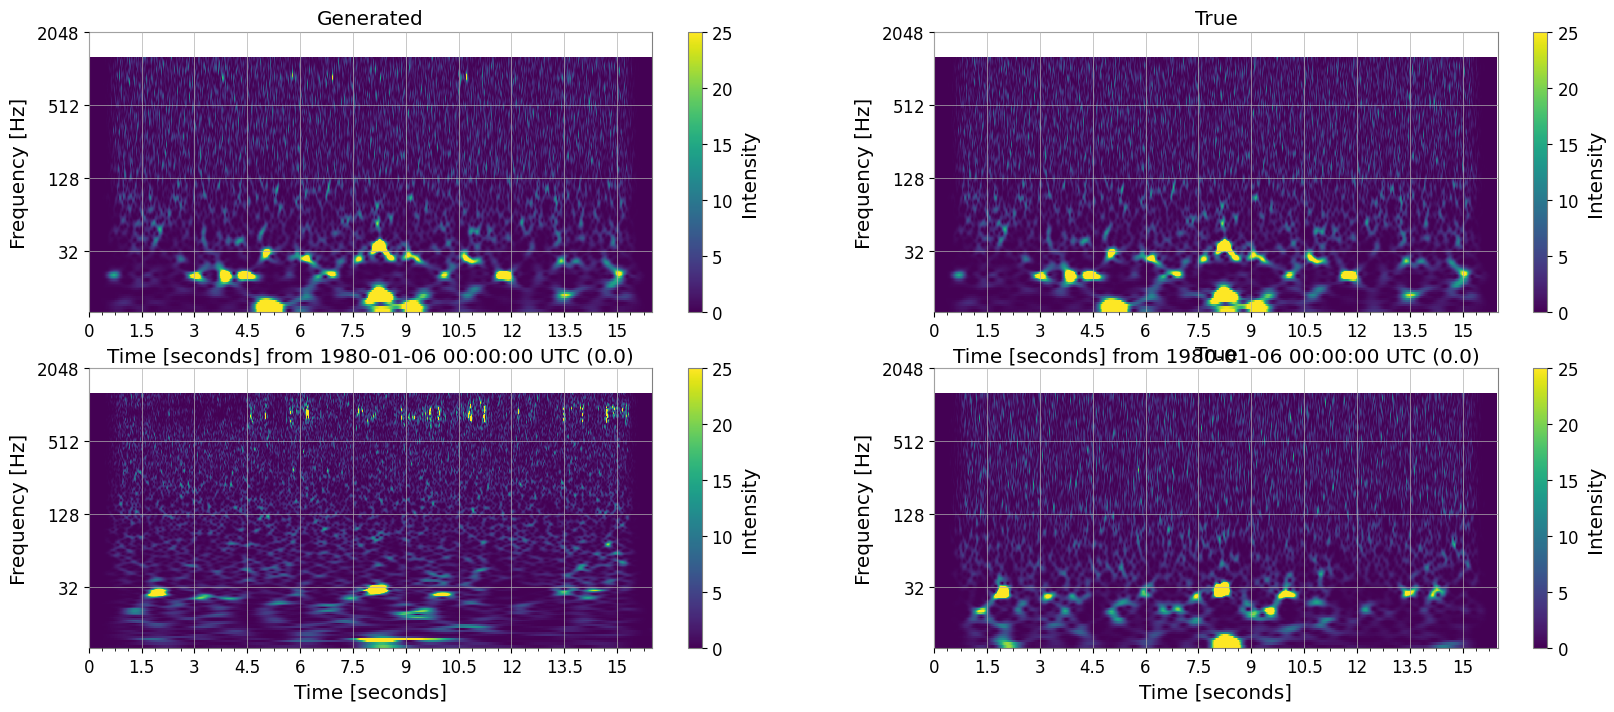

In [35]:
fig, ax = plt.subplots(n_data,2,figsize=[n_data*10, 8])
ax[0,0].set_title('Generated')
ax[0,1].set_title('True')
ax[-1,0].set_xlabel('Time [seconds]')
ax[-1,1].set_xlabel('Time [seconds]')
for i in range(n_data):
    tmsrs=TimeSeries(generated[i][0].cpu().numpy())
    tmsrs.dt=1.0/4096.0
    tmsrs=tmsrs.whiten()
    qspecgram = tmsrs.q_transform(frange=(10,2048))
    plot = ax[i,0].imshow(qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    # Set x-axis scale to seconds
    ax[i,0].set_xscale('seconds')

    # Set y-axis scale to log with base 2
    ax[i,0].set_yscale('log', base=2)
    ax[i,0].set_ylim(10, 2048)
    #ax.set_xlim(gps-2, gps+2)

    # Set labels and colorbar
    ax[i,0].set_ylabel('Frequency [Hz]')
    cbar = plt.colorbar(plot, label='Intensity')


    tmsrs=TimeSeries(batch[i][0].cpu().numpy())
    tmsrs.dt=1.0/4096.0
    tmsrs=tmsrs.whiten()
    qspecgram = tmsrs.q_transform(frange=(10,2048))
    plot = ax[i,1].imshow(qspecgram, cmap='viridis', aspect='auto', origin='lower', vmin=0, vmax=25)
    ax[i,1].set_title('True')
    # Set x-axis scale to seconds
    ax[i,1].set_xscale('seconds')

    # Set y-axis scale to log with base 2
    ax[i,1].set_yscale('log', base=2)
    ax[i,1].set_ylim(10, 2048)
    #ax.set_xlim(gps-2, gps+2)

    # Set labels and colorbar
    ax[i,1].set_ylabel('Frequency [Hz]')
    cbar = plt.colorbar(plot, label='Intensity')

plt.show()